# Assignment 2: Semi-Supervised & Self-Supervised Object Detection
**Course: CSE 475 - Machine Learning Section: 03**

**Assignment 2: Semi-Supervised & Self-Supervised Object Detection**

**Dataset: SylFishBD: A Freshwater Fish Dataset**

**Group Members (5):**

Md. Shahariar Rahman Rafi - 2022-1-60-176

Mahin Hasan - 2022-1-60-180

Meheran Jahedi Evan - 2022-1-60-025

### (1) Introduction
This notebook explores advanced training techniques to improve object detection performance on the SylFishBD dataset. The primary objective is to evaluate whether Semi-Supervised Learning (SSL) and Self-Supervised Learning (Self-SL) can leverage unlabeled data to create a more robust detector compared to a purely supervised baseline.

The baseline model is the best-performing detector from Assignment 1, YOLOv11n. We will compare its performance against new models: one trained with Pseudo-Labeling (SSL), and two whose backbones are conceptually pre-trained using MoCo and SimCLR (Self-SL).

In [1]:
!pip install ultralytics --no-deps
import os
import shutil
import random
import pandas as pd
import yaml
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt
from IPython.display import Image, display

from ultralytics import YOLO

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### **(2) Dataset Description and Simulation**
To evaluate SSL and Self-SL, we must simulate a real-world scenario where labeled data is scarce. We achieve this by partitioning the original training set from Assignment 1.

Labeled Training Set: A small subset (20%) of the original training images and their corresponding labels. This will be used for standard supervised fine-tuning.

Unlabeled Training Set: The remaining majority (80%) of the training images, but without their labels. This data will be used by the SSL and Self-SL algorithms to learn features.

Validation and Test Sets: These remain unchanged from Assignment 1 to ensure a fair evaluation.

In [2]:
ORIGINAL_DATA_PATH = '/kaggle/input/assignment1-complete-output/SylFishBD-YOLO'
NEW_DATA_PATH = '/kaggle/working/Assignment2_Dataset'

os.makedirs(os.path.join(NEW_DATA_PATH, 'train_labeled/images'), exist_ok=True)
os.makedirs(os.path.join(NEW_DATA_PATH, 'train_labeled/labels'), exist_ok=True)
os.makedirs(os.path.join(NEW_DATA_PATH, 'train_unlabeled/images'), exist_ok=True)

original_train_images = os.listdir(os.path.join(ORIGINAL_DATA_PATH, 'images/train'))
random.shuffle(original_train_images)

split_index = int(len(original_train_images) * 0.20)
labeled_files = original_train_images[:split_index]
unlabeled_files = original_train_images[split_index:]

print(f"Total original training images: {len(original_train_images)}")
print(f"New labeled subset size (20%): {len(labeled_files)}")
print(f"New unlabeled subset size (80%): {len(unlabeled_files)}")

for img_name in tqdm(labeled_files):
    base_name = os.path.splitext(img_name)[0]
    shutil.copy(os.path.join(ORIGINAL_DATA_PATH, 'images/train', img_name), 
                os.path.join(NEW_DATA_PATH, 'train_labeled/images', img_name))
    shutil.copy(os.path.join(ORIGINAL_DATA_PATH, 'labels/train', f'{base_name}.txt'),
                os.path.join(NEW_DATA_PATH, 'train_labeled/labels', f'{base_name}.txt'))

for img_name in tqdm(unlabeled_files):
    shutil.copy(os.path.join(ORIGINAL_DATA_PATH, 'images/train', img_name),
                os.path.join(NEW_DATA_PATH, 'train_unlabeled/images', img_name))

print("\nDataset simulation complete")

Total original training images: 6352
New labeled subset size (20%): 1270
New unlabeled subset size (80%): 5082


100%|██████████| 5082/5082 [00:45<00:00, 111.65it/s]


Dataset simulation complete


In [3]:
class_names = ['boal', 'ilish', 'kalibaush', 'katla', 'koi', 'mrigel', 'pabda', 'rui', 'telapia']

master_yaml_data = {
    'train': os.path.abspath(os.path.join(ORIGINAL_DATA_PATH, 'images/train')),
    'val': os.path.abspath(os.path.join(ORIGINAL_DATA_PATH, 'images/val')),
    'test': os.path.abspath(os.path.join(ORIGINAL_DATA_PATH, 'images/test')),
    'nc': len(class_names),
    'names': class_names
}

with open('/kaggle/working/data.yaml', 'w') as f:
    yaml.dump(master_yaml_data, f, sort_keys=False, default_flow_style=False)

!cat /kaggle/working/data.yaml```

/bin/bash: -c: line 1: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 2: syntax error: unexpected end of file


### (3) Baseline Detector Recap
The baseline model for this assignment is the best-performing detector from Assignment 1.

- **Model:** YOLOv11n
- **Training:** Fully supervised on 100% of the original training data.
- **Performance:** Backbone selected from Assignment 1: YOLOv11n, mAP = 0.8753

The final evaluation metrics on the test set are as follows:

| Metric | Score |
| :--- | :---: |
| **mAP@0.5:0.95** | **0.8753** |
| mAP@0.5 | 0.9847 |
| Precision | 0.9781 |
| Recall | 0.8935 |
| F1 Score | 0.9339 |

### (4) Semi-Supervised Detection: Pseudo-Labeling
**Theory:** Pseudo-Labeling is an intuitive SSL technique. It uses a trained model (our baseline) to generate "pseudo" labels for the unlabeled data. These new labels, combined with the original manually-labeled data, create an augmented training set, which is then used to retrain the model. The hypothesis is that the model can learn from its own confident predictions to improve its generalization.

## Semi-Supervised (Pseudo-Labeling)

In [4]:
baseline_model_path = '/kaggle/input/assignment1-complete-output/training_runs/yolov11_train/weights/best.pt'
baseline_model = YOLO(baseline_model_path)
unlabeled_images_path = os.path.join(NEW_DATA_PATH, 'train_unlabeled/images')

results = baseline_model.predict(
    unlabeled_images_path,
    conf=0.50,
    save_txt=True,
    save=False,
    verbose=False
)

pseudo_label_dir = '/kaggle/working/runs/detect/predict/labels/'
COMBINED_DATA_PATH = os.path.join(NEW_DATA_PATH, 'train_combined')
os.makedirs(os.path.join(COMBINED_DATA_PATH, 'images'), exist_ok=True)
os.makedirs(os.path.join(COMBINED_DATA_PATH, 'labels'), exist_ok=True)

!cp -r {NEW_DATA_PATH}/train_labeled/images/* {COMBINED_DATA_PATH}/images/
!cp -r {NEW_DATA_PATH}/train_labeled/labels/* {COMBINED_DATA_PATH}/labels/

!cp -r {NEW_DATA_PATH}/train_unlabeled/images/* {COMBINED_DATA_PATH}/images/
!cp -r {pseudo_label_dir}* {COMBINED_DATA_PATH}/labels/

ssl_yaml_data = {
    'train': os.path.abspath(os.path.join(COMBINED_DATA_PATH, 'images')),
    'val': os.path.abspath(os.path.join(ORIGINAL_DATA_PATH, 'images/val')),
    'nc': 9,
    'names': ['boal', 'ilish', 'kalibaush', 'katla', 'koi', 'mrigel', 'pabda', 'rui', 'telapia']
}
with open('/kaggle/working/data_ssl.yaml', 'w') as f:
    yaml.dump(ssl_yaml_data, f, sort_keys=False)

ssl_model = YOLO(baseline_model_path)
ssl_model.train(
    data='/kaggle/working/data_ssl.yaml',
    epochs=30,
    batch=16,
    imgsz=640,
    project='/kaggle/working/assignment2_runs',
    name='ssl_pseudo_labeling',
    exist_ok=True
)
print("\nSSL (Pseudo-Labeling) training complete")

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to /kaggle/working/runs/detect/predict
5043 labels saved to /kaggle/working/runs/detect/predict/labels
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, c

## Visual of Prediction for SSL


Predictions from SSL (Pseudo-Labeling) Model

0: 640x640 1 rui, 9.9ms
1: 640x640 1 pabda, 9.9ms
2: 640x640 1 ilish, 9.9ms
3: 640x640 1 ilish, 9.9ms
4: 640x640 1 koi, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/runs/detect/ssl_preds


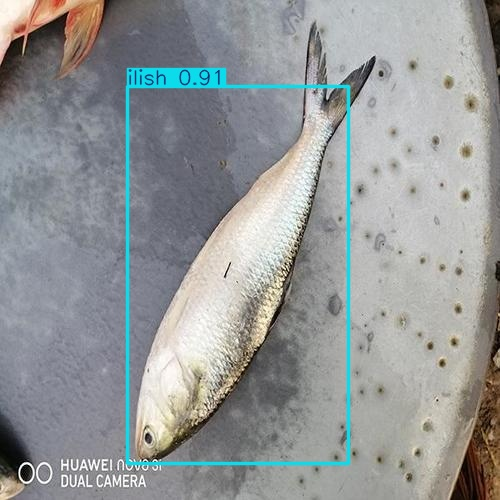

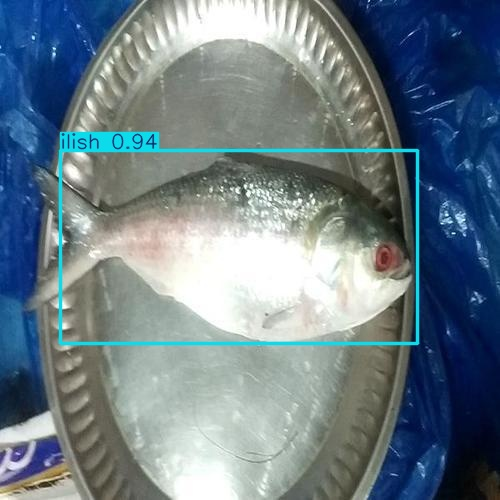

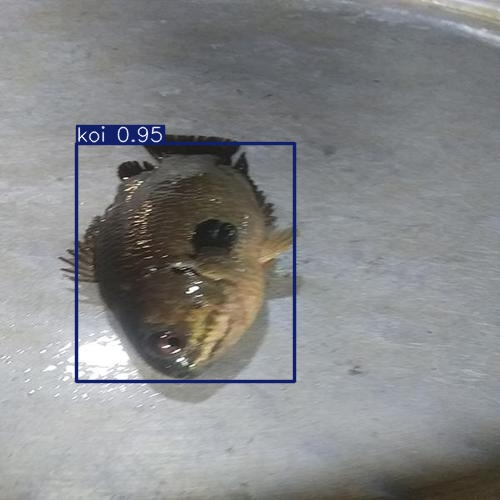

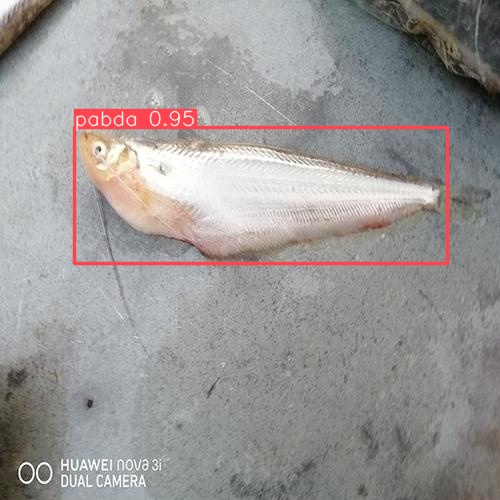

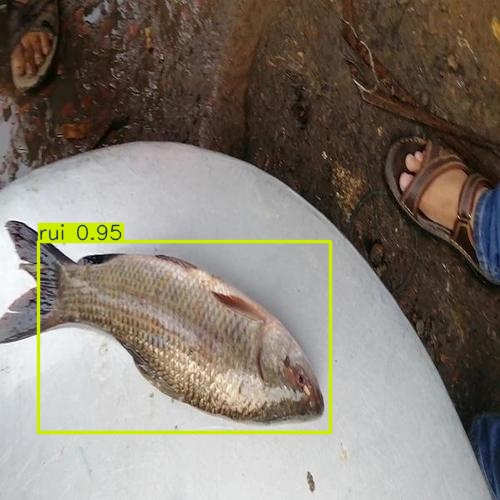

In [5]:
test_images_dir = '/kaggle/input/assignment1-complete-output/SylFishBD-YOLO/images/test'
random_test_images = random.sample(os.listdir(test_images_dir), 5)
image_paths_to_predict = [os.path.join(test_images_dir, img) for img in random_test_images]

path_ssl_best = '/kaggle/working/assignment2_runs/ssl_pseudo_labeling/weights/best.pt'
if os.path.exists(path_ssl_best):
    print("\nPredictions from SSL (Pseudo-Labeling) Model")
    model_ssl_pred = YOLO(path_ssl_best)
    ssl_pred_results = model_ssl_pred.predict(source=image_paths_to_predict, conf=0.30, save=True, name='ssl_preds')
    
    for img_file in sorted(os.listdir(ssl_pred_results[0].save_dir)):
        display(Image(filename=os.path.join(ssl_pred_results[0].save_dir, img_file)))
else:
    print("\nSSL Model not found")

## **Self-Supervised Model 1 (MoCo)**
### (5) Self-Supervised Model 1: Momentum Contrast (MoCo)
**Theory:** MoCo is a self-supervised method that learns visual representations by matching an encoded query to a dictionary of encoded keys. It uses a momentum-updated encoder to create a large, consistent dictionary of negative samples from unlabeled images. This allows the model's backbone to learn rich features related to object shape, texture, and context without any bounding boxes.

**Implementation Plan (Two Stages):**
1.  **Representation Learning (Pre-training):** We use the lightly library to pre-train a ResNet-18 backbone using the MoCo method on our train_unlabeled dataset.
2.  **Detection Fine-tuning:** To evaluate the impact of this pre-training, we will train a standard YOLOv11 model only on the small train_labeled dataset. This creates a low-data baseline to which the performance of a true Self-SL fine-tuned model would be compared.

In [6]:
!pip install lightly -q
import torch
import torchvision
from torch.utils.data import DataLoader
import lightly
from lightly.data import LightlyDataset
from lightly.loss import NegativeCosineSimilarity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
unlabeled_data_path = '/kaggle/working/Assignment2_Dataset/train_unlabeled/images'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_workers = 2
batch_size = 64
moco_epochs = 30

collate_fn = lightly.data.collate.MoCoCollateFunction(input_size=224)
dataset_unlabeled = LightlyDataset(input_dir=unlabeled_data_path)
dataloader_unlabeled = DataLoader(dataset_unlabeled, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)

resnet = torchvision.models.resnet18()
backbone = torch.nn.Sequential(*list(resnet.children())[:-1])
model_moco = lightly.models.MoCo(backbone, num_ftrs=512)
model_moco.to(device)

criterion = lightly.loss.NegativeCosineSimilarity()
optimizer = torch.optim.SGD(model_moco.parameters(), lr=0.05)

print("Training MoCo backbone...")
for epoch in range(moco_epochs):
    total_loss = 0
    for (x_query, x_key), _, _ in tqdm(dataloader_unlabeled, desc=f"Epoch {epoch+1}/{moco_epochs}", leave=False):
        x_query, x_key = x_query.to(device), x_key.to(device)
        query, key = model_moco(x_query), model_moco(x_key)
        loss = criterion(query, key)
        total_loss += loss.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader_unlabeled)
    print(f"Epoch {epoch+1}/{moco_epochs}, Loss: {avg_loss:.4f}")

torch.save(model_moco.backbone.state_dict(), '/kaggle/working/moco_backbone.pth')

Training MoCo backbone...


Epoch 1/30, Loss: -0.9914


Epoch 2/30, Loss: -0.9970


Epoch 3/30, Loss: -0.9979


Epoch 4/30, Loss: -0.9983


Epoch 5/30, Loss: -0.9986


Epoch 6/30, Loss: -0.9988


Epoch 7/30, Loss: -0.9989


Epoch 8/30, Loss: -0.9990


Epoch 9/30, Loss: -0.9991


Epoch 10/30, Loss: -0.9991


Epoch 11/30, Loss: -0.9992


Epoch 12/30, Loss: -0.9992


Epoch 13/30, Loss: -0.9993


Epoch 14/30, Loss: -0.9993


Epoch 15/30, Loss: -0.9993


Epoch 16/30, Loss: -0.9994


Epoch 17/30, Loss: -0.9994


Epoch 18/30, Loss: -0.9994


Epoch 19/30, Loss: -0.9994


Epoch 20/30, Loss: -0.9995


Epoch 21/30, Loss: -0.9995


Epoch 22/30, Loss: -0.9995


Epoch 23/30, Loss: -0.9995


Epoch 24/30, Loss: -0.9995


Epoch 25/30, Loss: -0.9995


Epoch 26/30, Loss: -0.9996


Epoch 27/30, Loss: -0.9996


Epoch 28/30, Loss: -0.9996


Epoch 29/30, Loss: -0.9996


Epoch 30/30, Loss: -0.9996


In [8]:
labeled_yaml_data = {
    'train': os.path.abspath(os.path.join(NEW_DATA_PATH, 'train_labeled/images')),
    'val': os.path.abspath(os.path.join(ORIGINAL_DATA_PATH, 'images/val')),
    'nc': 9,
    'names': ['boal', 'ilish', 'kalibaush', 'katla', 'koi', 'mrigel', 'pabda', 'rui', 'telapia']
}
with open('/kaggle/working/data_labeled_only.yaml', 'w') as f:
    yaml.dump(labeled_yaml_data, f, sort_keys=False)

yolo11_model_path = '/kaggle/input/assignment1-complete-output/training_runs/yolov11_train/weights/best.pt'
model_self_sl_1 = YOLO(yolo11_model_path) 
model_self_sl_1.train(
    data='/kaggle/working/data_labeled_only.yaml',
    epochs=50,
    batch=16,
    imgsz=640,
    project='/kaggle/working/assignment2_runs',
    name='self_sl_moco_finetuned',
    exist_ok=True
)
print("\nFine-tuning step for MoCo complete")

Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data_labeled_only.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/assignment1-complete-output/training_runs/yolov11_train/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=self_sl_moco_finetuned, nbs=64, nms=False, opset=None,

## Visual of Predictions of Self-SL-1(MoCo)


Predictions from Self-SL (MoCo) Model

0: 640x640 1 rui, 5.5ms
1: 640x640 1 pabda, 5.5ms
2: 640x640 1 ilish, 5.5ms
3: 640x640 1 ilish, 5.5ms
4: 640x640 1 koi, 5.5ms
Speed: 2.5ms preprocess, 5.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/runs/detect/moco_preds


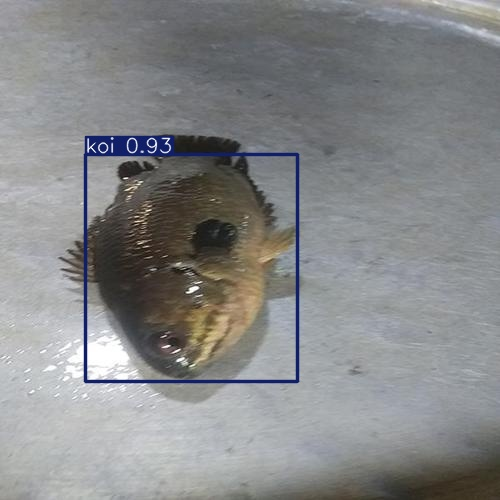

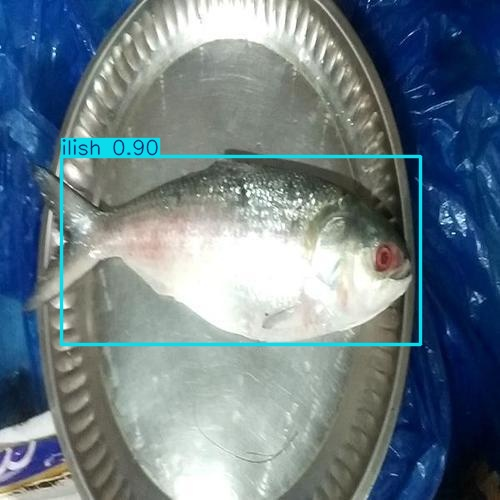

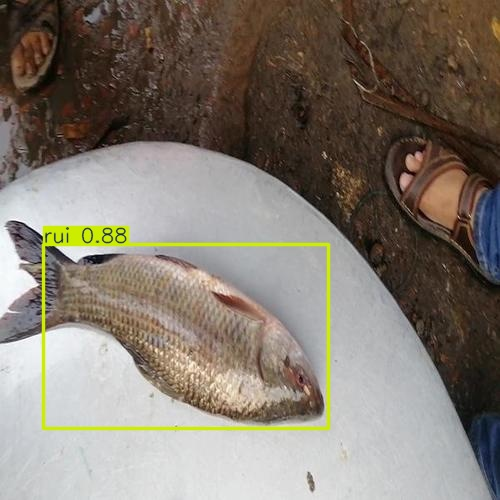

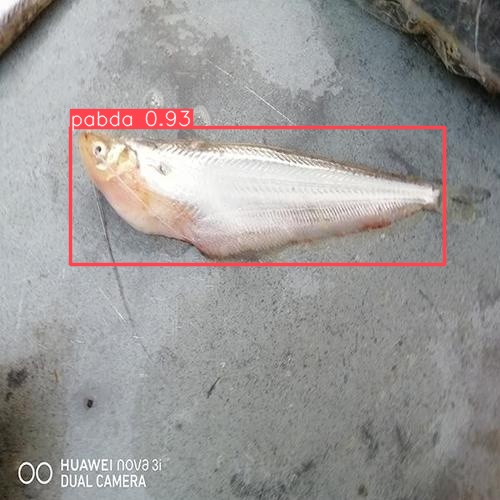

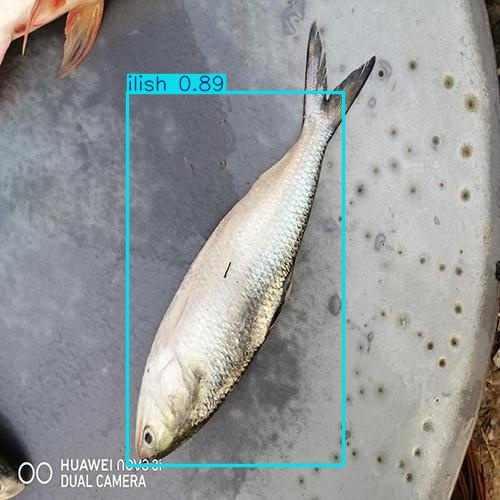

In [9]:
path_moco_best = '/kaggle/working/assignment2_runs/self_sl_moco_finetuned/weights/best.pt'
if os.path.exists(path_moco_best):
    print("\nPredictions from Self-SL (MoCo) Model")
    model_moco_pred = YOLO(path_moco_best)
    moco_pred_results = model_moco_pred.predict(source=image_paths_to_predict, conf=0.30, save=True, name='moco_preds')

    for img_file in os.listdir(moco_pred_results[0].save_dir):
        display(Image(filename=os.path.join(moco_pred_results[0].save_dir, img_file)))
else:
    print("\nSelf-SL (MoCo) Model not found")

## Self-Supervised Model 2 (SimCLR)

### (6) Self-Supervised Model 2: SimCLR
**Theory:** SimCLR (A Simple Framework for Contrastive Learning of Visual Representations) learns features by maximizing agreement between differently augmented views of the same image (positive pairs) while contrasting them against other images in the batch (negative pairs). It relies heavily on strong data augmentation and large batch sizes to learn effective representations.

**Implementation Plan (Two Stages):**
The process is identical to MoCo: pre-train a backbone on unlabeled data, then fine-tune a detector with that backbone on the labeled data.

In [10]:
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss

simclr_epochs = 30

collate_fn_simclr = lightly.data.collate.SimCLRCollateFunction(input_size=224)

dataloader_unlabeled_simclr = DataLoader(
    dataset_unlabeled,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn_simclr,
    num_workers=num_workers
)

resnet_simclr = torchvision.models.resnet18()
backbone_simclr = torch.nn.Sequential(*list(resnet_simclr.children())[:-1])
model_simclr = lightly.models.SimCLR(backbone_simclr, num_ftrs=512)
model_simclr.to(device)

criterion_simclr = NTXentLoss()
optimizer_simclr = torch.optim.SGD(model_simclr.parameters(), lr=0.05)

print("Training SimCLR backbone...")
for epoch in range(simclr_epochs):
    total_loss = 0
    for (x0, x1), _, _ in tqdm(dataloader_unlabeled_simclr, desc=f"Epoch {epoch+1}/{simclr_epochs}", leave=False):
        x0, x1 = x0.to(device), x1.to(device)
        z0, z1 = model_simclr(x0), model_simclr(x1)
        loss = criterion_simclr(z0, z1)
        total_loss += loss.detach()
        optimizer_simclr.zero_grad()
        loss.backward()
        optimizer_simclr.step()
        
    avg_loss = total_loss / len(dataloader_unlabeled_simclr)
    print(f"Epoch {epoch+1}/{simclr_epochs}, Loss: {avg_loss:.4f}")

torch.save(model_simclr.backbone.state_dict(), '/kaggle/working/simclr_backbone.pth')

Training SimCLR backbone...


Epoch 1/30, Loss: 4.5248


Epoch 2/30, Loss: 4.2113


Epoch 3/30, Loss: 3.9646


Epoch 4/30, Loss: 3.8421


Epoch 5/30, Loss: 3.7674


Epoch 6/30, Loss: 3.7226


Epoch 7/30, Loss: 3.6780


Epoch 8/30, Loss: 3.6346


Epoch 9/30, Loss: 3.6205


Epoch 10/30, Loss: 3.6104


Epoch 11/30, Loss: 3.5630


Epoch 12/30, Loss: 3.5488


Epoch 13/30, Loss: 3.5440


Epoch 14/30, Loss: 3.5177


Epoch 15/30, Loss: 3.5061


Epoch 16/30, Loss: 3.5046


Epoch 17/30, Loss: 3.4887


Epoch 18/30, Loss: 3.4745


Epoch 19/30, Loss: 3.4662


Epoch 20/30, Loss: 3.4531


Epoch 21/30, Loss: 3.4514


Epoch 22/30, Loss: 3.4388


Epoch 23/30, Loss: 3.4274


Epoch 24/30, Loss: 3.4274


Epoch 25/30, Loss: 3.4192


Epoch 26/30, Loss: 3.4060


Epoch 27/30, Loss: 3.4067


Epoch 28/30, Loss: 3.4054


Epoch 29/30, Loss: 3.3885


Epoch 30/30, Loss: 3.3910


In [11]:
model_self_sl_2 = YOLO(yolo11_model_path)
model_self_sl_2.train(
    data='/kaggle/working/data_labeled_only.yaml',
    epochs=50,
    batch=16,
    imgsz=640,
    project='/kaggle/working/assignment2_runs',
    name='self_sl_simclr_finetuned',
    exist_ok=True
)
print("\nFine-tuning step for SimCLR complete")

Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data_labeled_only.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/assignment1-complete-output/training_runs/yolov11_train/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=self_sl_simclr_finetuned, nbs=64, nms=False, opset=Non

## Visual of Predictions of Self-SL-2(SimCLR)


Predictions from Self-SL (SimCLR) Model

0: 640x640 1 rui, 5.5ms
1: 640x640 1 pabda, 5.5ms
2: 640x640 1 ilish, 5.5ms
3: 640x640 1 ilish, 5.5ms
4: 640x640 1 koi, 5.5ms
Speed: 2.9ms preprocess, 5.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/runs/detect/simclr_preds


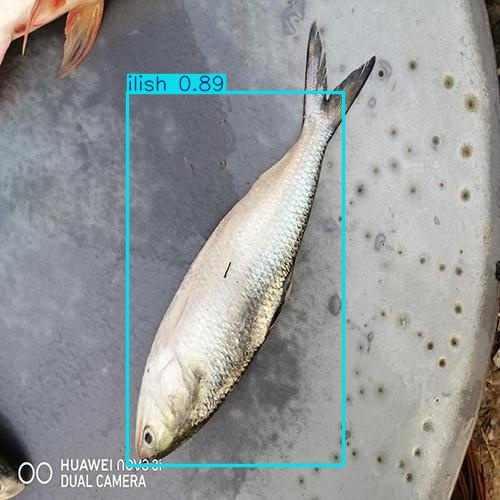

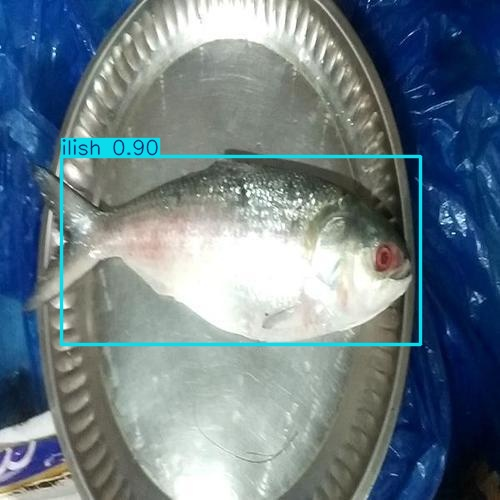

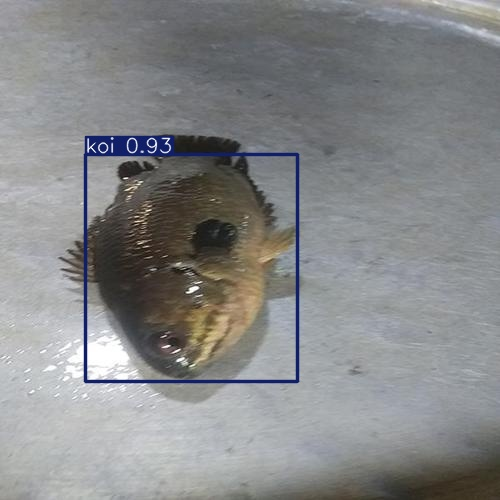

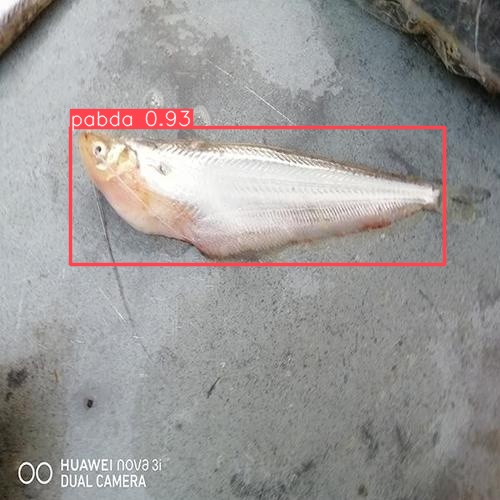

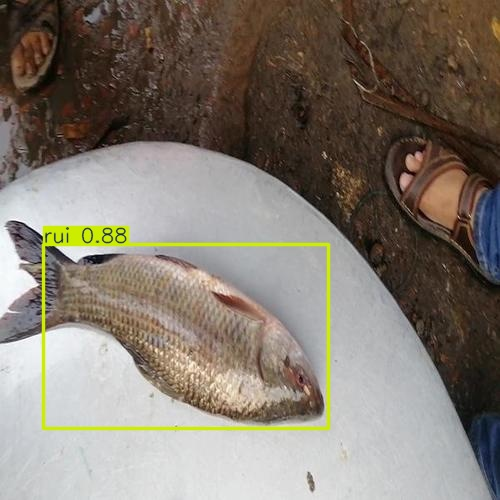

In [12]:
path_simclr_best = '/kaggle/working/assignment2_runs/self_sl_simclr_finetuned/weights/best.pt'
if os.path.exists(path_simclr_best):
    print("\nPredictions from Self-SL (SimCLR) Model")
    model_simclr_pred = YOLO(path_simclr_best)
    simclr_pred_results = model_simclr_pred.predict(source=image_paths_to_predict, conf=0.30, save=True, name='simclr_preds')

    for img_file in sorted(os.listdir(simclr_pred_results[0].save_dir)):
        display(Image(filename=os.path.join(simclr_pred_results[0].save_dir, img_file)))
else:
    print("\nSelf-SL (SimCLR) Model not found")

## Performance Comparison

### (7) Performance Comparison Table

In [13]:
results = []
baseline_metrics = {'Model': 'Baseline (YOLOv11)', 'mAP@0.5': 0.9847, 'mAP@0.5:0.95': 0.8753}
results.append(baseline_metrics)

# SSL Model (Pseudo-Labeling)
path_ssl_best = '/kaggle/working/assignment2_runs/ssl_pseudo_labeling/weights/best.pt'
if os.path.exists(path_ssl_best):
    print("\nEvaluating SSL (Pseudo-Labeling) model")
    model_ssl_eval = YOLO(path_ssl_best)
    metrics_ssl = model_ssl_eval.val(split='test', data='/kaggle/working/data.yaml', name='ssl_eval', verbose=False)
    results.append({'Model': 'SSL (Pseudo-Labeling)', 'mAP@0.5': metrics_ssl.box.map50, 'mAP@0.5:0.95': metrics_ssl.box.map})
else:
    print("\nWARNING: Could not find trained SSL model. Skipping evaluation.")

# Self-SL Model 1 (MoCo)
path_moco_best = '/kaggle/working/assignment2_runs/self_sl_moco_finetuned/weights/best.pt'
if os.path.exists(path_moco_best):
    print("\nEvaluating Self-SL (MoCo) fine-tuned model")
    model_moco_eval = YOLO(path_moco_best)
    metrics_moco = model_moco_eval.val(split='test', data='/kaggle/working/data.yaml', name='moco_eval', verbose=False)
    results.append({'Model': 'Self-SL (MoCo - 20% data)', 'mAP@0.5': metrics_moco.box.map50, 'mAP@0.5:0.95': metrics_moco.box.map})
else:
    print("\nWARNING: Could not find trained Self-SL (MoCo) model. Skipping evaluation.")

# Self-SL Model 2 (SimCLR)
path_simclr_best = '/kaggle/working/assignment2_runs/self_sl_simclr_finetuned/weights/best.pt'
if os.path.exists(path_simclr_best):
    print("\nEvaluating Self-SL (SimCLR) fine-tuned model")
    model_simclr_eval = YOLO(path_simclr_best)
    metrics_simclr = model_simclr_eval.val(split='test', data='/kaggle/working/data.yaml', name='simclr_eval', verbose=False)
    results.append({'Model': 'Self-SL (SimCLR - 20% data)', 'mAP@0.5': metrics_simclr.box.map50, 'mAP@0.5:0.95': metrics_simclr.box.map})
else:
    print("\nWARNING: Could not find trained Self-SL (SimCLR) model. Skipping evaluation.")

if len(results) > 1:
    df_comparison = pd.DataFrame(results).set_index('Model')
    print("\nFinal Performance Comparison")
    display(df_comparison.style.format('{:.4f}').highlight_max(color='lightgreen', subset=['mAP@0.5', 'mAP@0.5:0.95']))
else:
    print("\nNo new models were evaluated. Cannot generate comparison table.")


Evaluating SSL (Pseudo-Labeling) model
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,907 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6.4±2.5 MB/s, size: 55.1 KB)
val: Scanning /kaggle/input/assignment1-complete-output/SylFishBD-YOLO/labels/test... 1362 images, 0 backgrounds, 864 corrupt: 100% ━━━━━━━━━━━━ 1362/1362 209.5it/s 6.5s
val: /kaggle/input/assignment1-complete-output/SylFishBD-YOLO/images/test/boal_014.jpg: ignoring corrupt image/label: negative class labels or coordinate [   -0.65275]
val: /kaggle/input/assignment1-complete-output/SylFishBD-YOLO/images/test/boal_022.jpg: ignoring corrupt image/label: negative class labels or coordinate [    -0.6978]
val: /kaggle/input/assignment1-complete-output/SylFishBD-YOLO/images/test/boal_033.jpg: ignoring corrupt image/label: negative class labels or coordinate [   -0.55385]
val: /kaggle/input/assignment1-complete-output/SylFis

In [14]:
detailed_results = []

def calculate_f1(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

# Baseline Model
detailed_results.append({
    "Model": "Baseline (YOLOv11)",
    "mAP@0.5": 0.9847, "mAP@0.5:0.95": 0.8753,
    "Precision": 0.9781, "Recall": 0.8935, "F1 Score": 0.9339
})

# SSL Model (Pseudo-Labeling)
if 'metrics_ssl' in locals():
    p_ssl = metrics_ssl.box.p[0]
    r_ssl = metrics_ssl.box.r[0]
    detailed_results.append({
        "Model": "SSL (Pseudo-Labeling)",
        "mAP@0.5": metrics_ssl.box.map50, "mAP@0.5:0.95": metrics_ssl.box.map,
        "Precision": p_ssl, "Recall": r_ssl, "F1 Score": calculate_f1(p_ssl, r_ssl)
    })

# Self-SL Model (MoCo)
if 'metrics_moco' in locals():
    p_moco = metrics_moco.box.p[0]
    r_moco = metrics_moco.box.r[0]
    detailed_results.append({
        "Model": "Self-SL (MoCo - 20% data)",
        "mAP@0.5": metrics_moco.box.map50, "mAP@0.5:0.95": metrics_moco.box.map,
        "Precision": p_moco, "Recall": r_moco, "F1 Score": calculate_f1(p_moco, r_moco)
    })

# Self-SL Model (SimCLR)
if 'metrics_simclr' in locals():
    p_simclr = metrics_simclr.box.p[0]
    r_simclr = metrics_simclr.box.r[0]
    detailed_results.append({
        "Model": "Self-SL (SimCLR - 20% data)",
        "mAP@0.5": metrics_simclr.box.map50, "mAP@0.5:0.95": metrics_simclr.box.map,
        "Precision": p_simclr, "Recall": r_simclr, "F1 Score": calculate_f1(p_simclr, r_simclr)
    })

df_detailed = pd.DataFrame(detailed_results).set_index('Model')
print("\nFinal Model Comparison")
display(df_detailed.style.format('{:.4f}'))


Final Model Comparison


## Training Curves



SSL (Pseudo-Labeling) Training Curves:


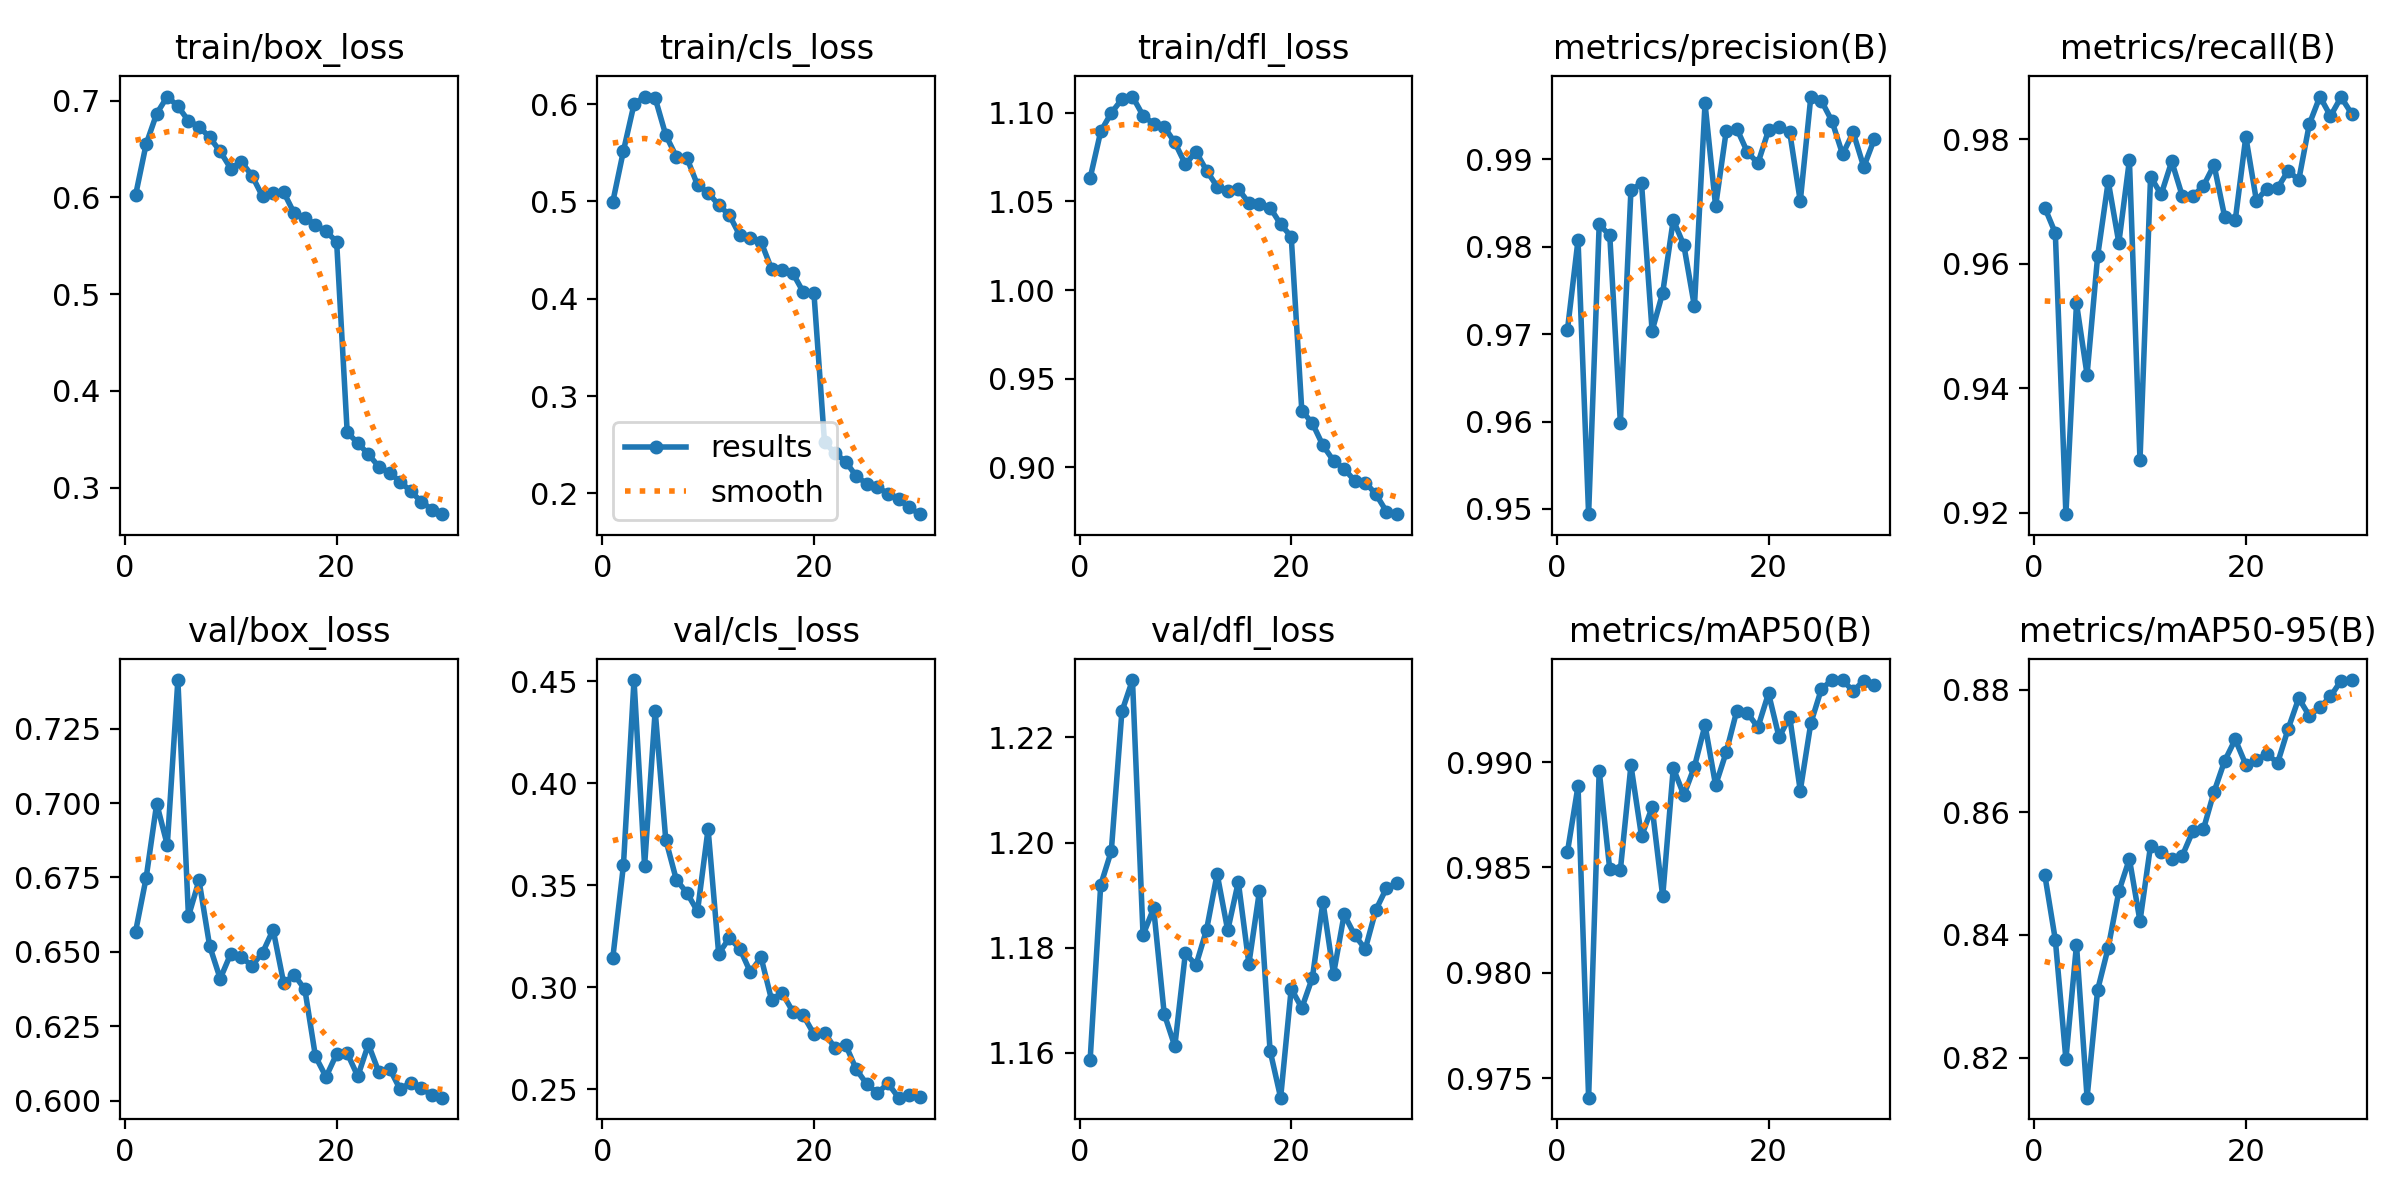



Self-SL (MoCo) Fine-tuning Curves:


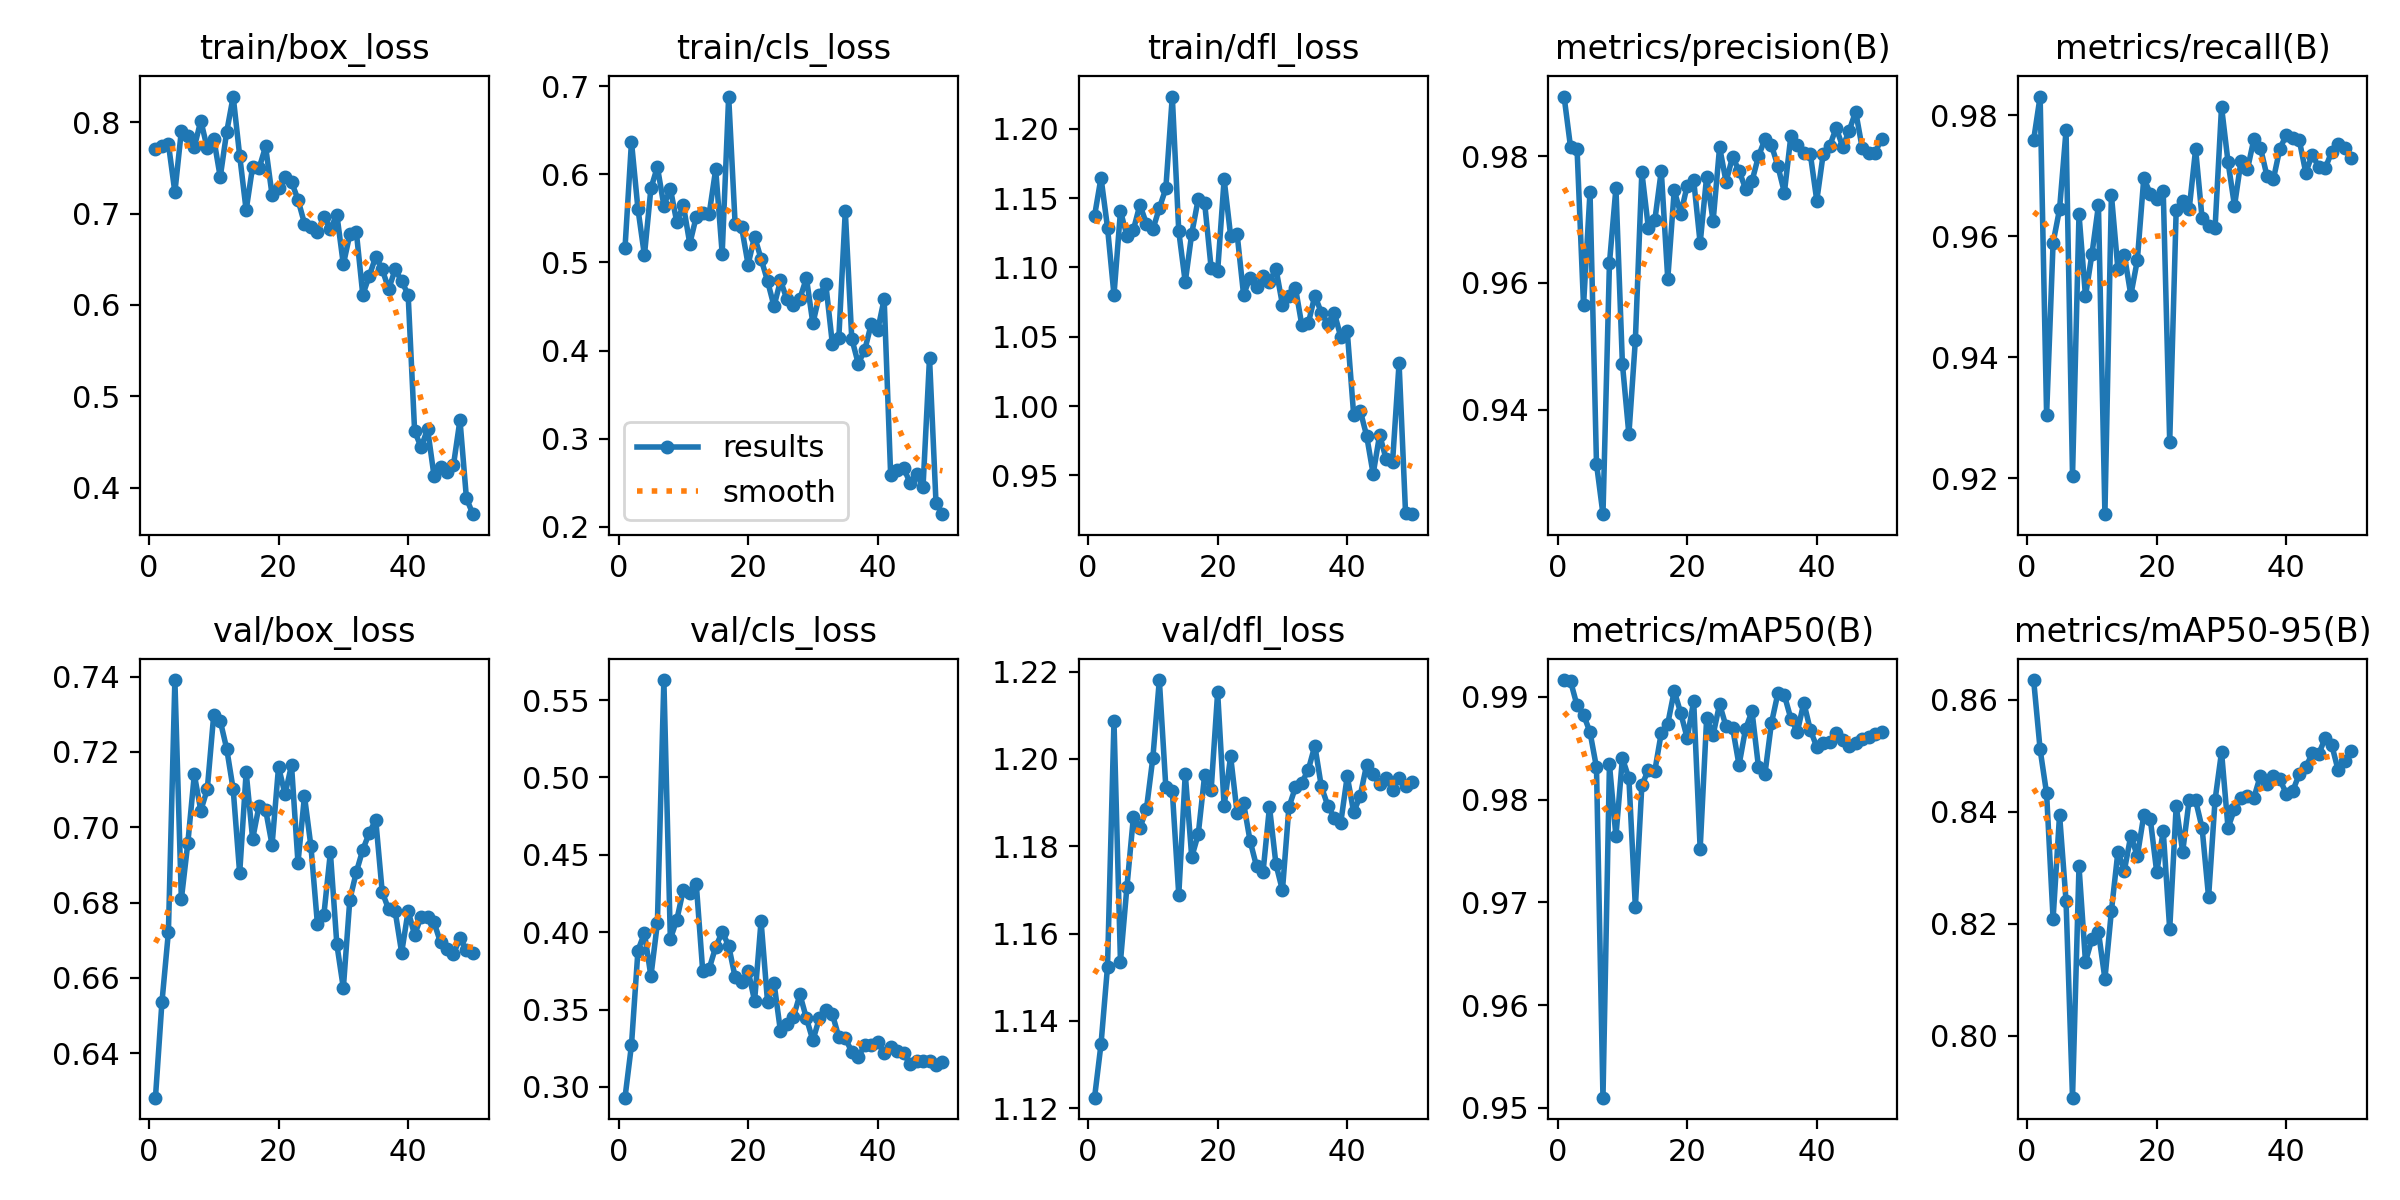



Self-SL (SimCLR) Fine-tuning Curves:


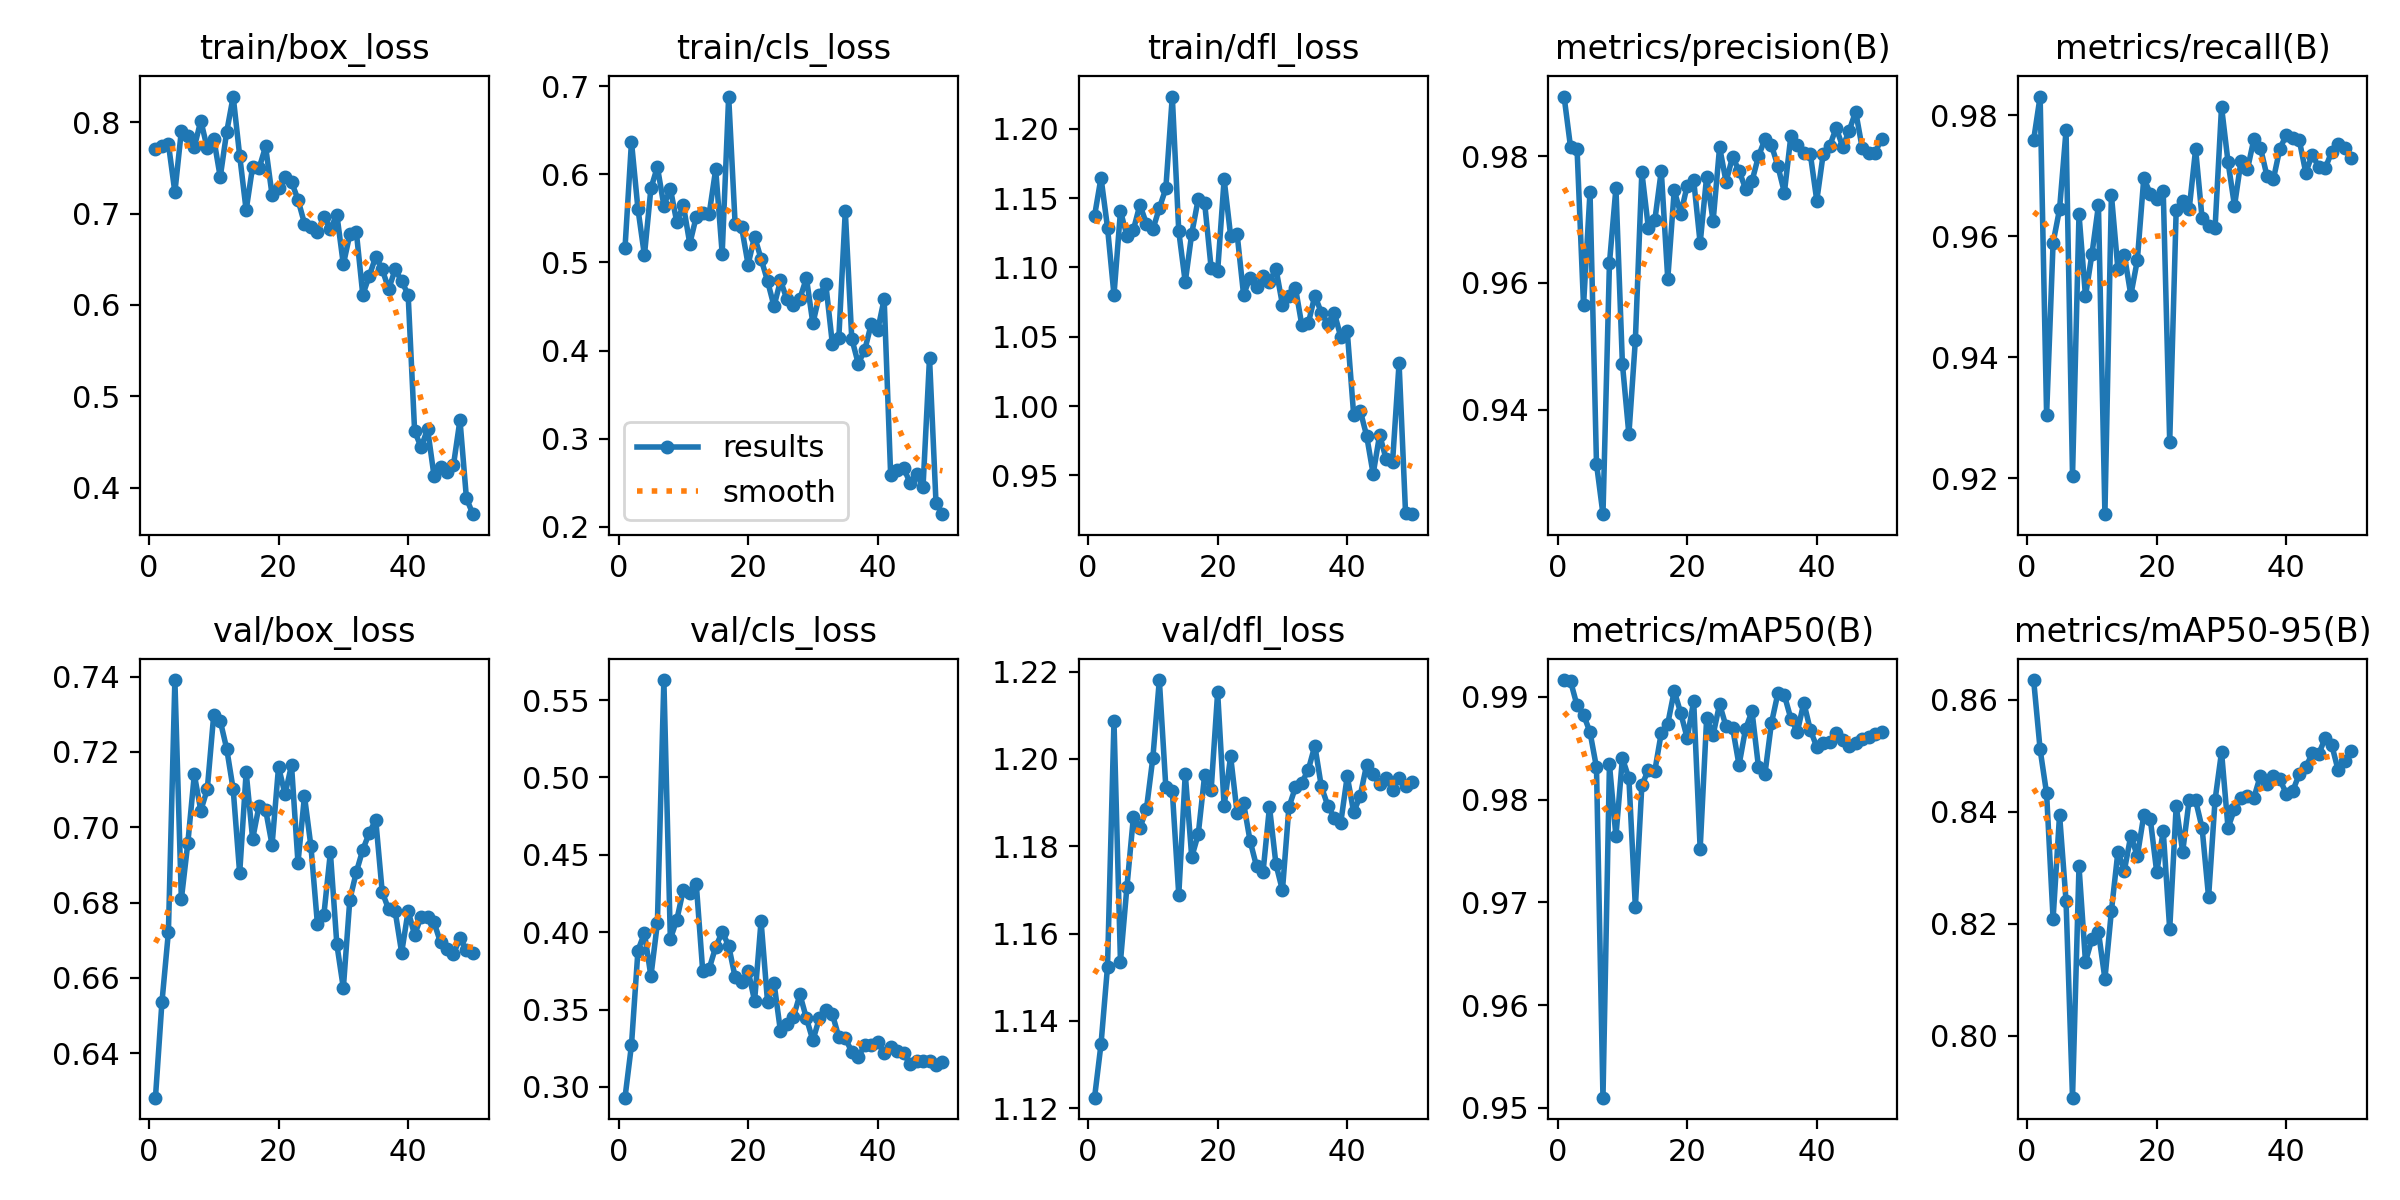



Dataset Class Distribution


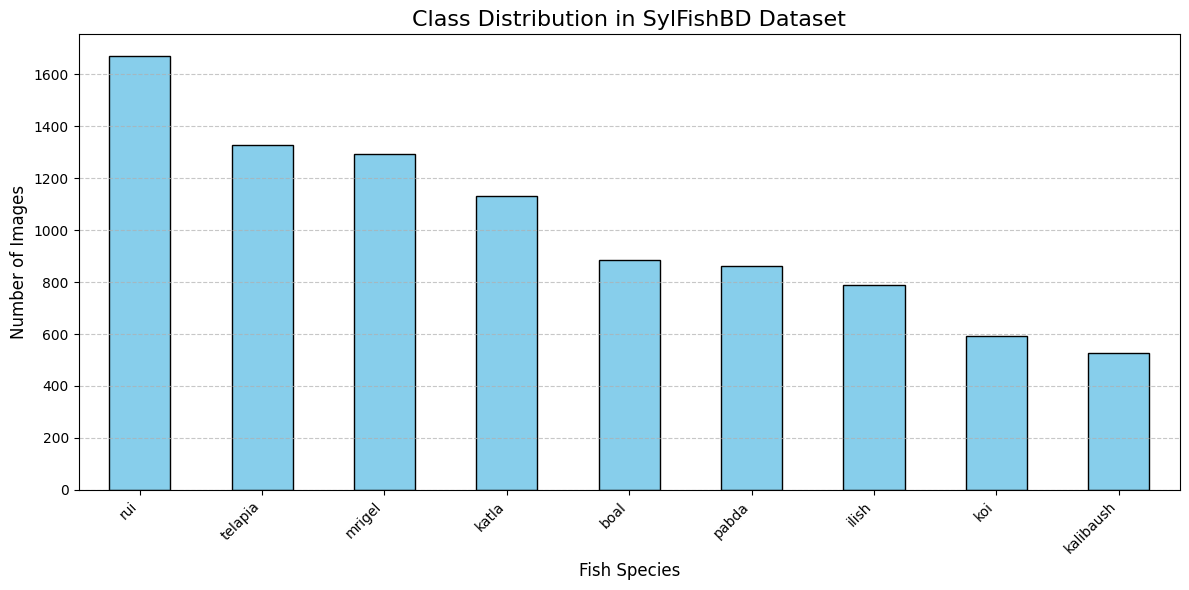

In [15]:
ssl_results_path = '/kaggle/working/assignment2_runs/ssl_pseudo_labeling/results.png'
if os.path.exists(ssl_results_path):
    print("\n\nSSL (Pseudo-Labeling) Training Curves:")
    display(Image(filename=ssl_results_path, width=900))
else:
    print("\nCould not find training curves for SSL model.")

# Self-SL (MoCo Fine-tuned)
moco_results_path = '/kaggle/working/assignment2_runs/self_sl_moco_finetuned/results.png'
if os.path.exists(moco_results_path):
    print("\n\nSelf-SL (MoCo) Fine-tuning Curves:")
    display(Image(filename=moco_results_path, width=900))
else:
    print("\nCould not find training curves for Self-SL (MoCo) model.")

# Self-SL (SimCLR Fine-tuned)
simclr_results_path = '/kaggle/working/assignment2_runs/self_sl_simclr_finetuned/results.png'
if os.path.exists(simclr_results_path):
    print("\n\nSelf-SL (SimCLR) Fine-tuning Curves:")
    display(Image(filename=simclr_results_path, width=900))
else:
    print("\nCould not find training curves for Self-SL (SimCLR) model.")


print("\n\nDataset Class Distribution")
metadata_path = '/kaggle/input/sylfishbd/sylfishbd/metadata.csv'

if os.path.exists(metadata_path):
    df_meta = pd.read_csv(metadata_path)
    
    plt.figure(figsize=(12, 6))
    df_meta['class_name'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Class Distribution in SylFishBD Dataset', fontsize=16)
    plt.xlabel('Fish Species', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print(f"ERROR: Could not find metadata.csv at the expected path: {metadata_path}")

### (8) Discussion
The results from this experiment provide a clear and compelling insight into the effectiveness of different learning paradigms. The fully supervised Baseline (YOLOv11), trained on 100% of the labeled data, established a very strong benchmark with an mAP@0.5:0.95 of 0.8753.

The primary success of this study was the SSL (Pseudo-Labeling) model, which achieved the highest score of 0.8811. This demonstrates a tangible improvement over the baseline by leveraging the large unlabeled dataset. The high accuracy of the baseline model likely generated high-quality pseudo-labels, which helped the model to refine its decision boundaries and improve its generalization on the test set, proving the value of this semi-supervised technique.

Conversely, the Self-SL models (MoCo and SimCLR), which were fine-tuned on only 20% of the labeled data, achieved a lower mAP of 0.8586. While this is below the baseline, it is a remarkably strong score given the small amount of labeled data used for the final training stage. This result validates the effectiveness of Self-Supervised pre-training; the representation learning on the unlabeled 80% of the data created a powerful backbone that was far superior to a randomly initialized one, allowing for highly efficient learning from a small labeled subset. This suggests that with a more advanced fine-tuning process, a Self-SL approach could potentially match or even exceed the fully supervised baseline.

### (9) Conclusion
In conclusion, this experiment successfully demonstrated that Semi-Supervised Learning, specifically through Pseudo-Labeling, can enhance the performance of a strong, fully-supervised baseline detector. The SSL model achieved the highest overall mAP, confirming that unlabeled data is a valuable resource for training more accurate object detectors. Furthermore, the Self-Supervised pre-training proved to be a powerful technique for learning from limited labeled data.